# Hacking CAPTCHAS using Machine Learning (I)
### Un-trained Neural Network Development
**by: Pablo Mateo**

# Situación Inicial
Queremos crear un sistema capaz de resolver CAPTCHAs para poder automatizar registros y envío de formularios.<br>
Para ello vamos a crear una **Red Neuronal** basada en **Redes Convolucionales** y **Aprendizaje Profundo** para entrenarla y que sea capaz de hacerlo de forma automática.<br>

## Machine Learning
Para utilizar Machine Learning, primero necesitamos un conjunto de datos con el que entrenar nuestros algoritmos para que determine patrones de identificación que, posteriormente, podrá aplicar para analizar muestras similares.

# Objetivo
Vamos a intentar Hackear uno de los Plugins de **Wordpress** más utilizados hasta hace poco para añadir un sistema de CAPTCHAs.<br>
Es importante destacar que el autor del plugin *recomienda usar otras alternativas* ya que este se ha quedado obsoleto y puede ser atacado por sistemas similares al que vamos a analizar en este ejercicio.<br><br>
El Plugin en cuestión se llama **Really Simple CAPTCHA** y cuenta actualmente con **+1.000.000** de instalaciones activas. Ha sido un Plugin muy conocido y destacado en el mundo de Wordpress.<br>
¡Hoy vamos a Hackearlo!

![title](CNN/imagesNotebook/plugin.png)

## Código Fuente
Respetando uno de los requisitos de un buen sistema de CAPTCHA (y el hecho de que es un Plugin de Wordpress), tenemos disponible el código fuente. Por tanto, podemos determinar cómo se generan las imágenes que utiliza este Plugin.<br><br>
[Código Fuente Really Simple CAPTCHA](https://plugins.trac.wordpress.org/browser/really-simple-captcha/trunk/really-simple-captcha.php)

## Análisis del Código
Analizando el código fuente, vemos 2 funciones interesantes que nos indican cómo se genera.<br>

### Construct
![algo](CNN/imagesNotebook/codigoRSC001.png)
<br>
Este primer método ya nos indica que se genera utilizando caracteres alfanuméricos A-Z + 2-9<br>
Destacamos que **omite el número 0 y el 1**, probablemente por su parecido con las letras O y l.<br>
Esto no hará más que facilitar el trabajo a nuestra Inteligencia Artificial.
También podemos observar que utiliza varias tipografías para complicar su análisis.<br>
El plugin genera una imagen de fondo blanco, con un tamaño de 72x74, con 4 caracteres de color negro a un tamaño 14 en formato .png.<br>
### Randomize
![algo](CNN/imagesNotebook/codigoRSC002.png)
<br>
Este segundo método nos indica cómo se genera la palabra de forma aleatoria.<br>
Matemáticamente sabemos que esto nos dará 289.986.840 combinaciones posibles teniendo en cuenta 4 tipografías diferentes.<br>
Como **recomendación de seguridad**, de instalar este Plugin, yo modificaría los parámetros por defecto.

## Herramientas
Para este proyecto utilizaremos una serie de herramientas:
- Python v3.0 -> Lenguage de Progrmación
- OpenCV -> Framework de procesamiento de imágenes muy utilizado en Computer Vision
- Keras -> Framework de Aprendizaje Profundo utilizado para entrenar Deep Neural Networks (Codificación de la red)
- TensorFlow -> Librería de Google para Machine Learning (Implementación de la red)

# Data Set
Para poder crear un sistema de Machine Learning, antes debemos reunir datos con los que poder entrenar al sistema.<br>
Básicamente, vamos a generar una red que, como input, le daremos una serie de imágenes generadas por el Plugin con su correspondiente solución. Codificaremos la red para que aprenda a detectar cada caracter y así, cuando le pasemos unos que nunca ha visto, sabrá cómo determinar lo que pone.<br><br>
Debido al alto número de posibles combinaciones y a las peculiaridades de algunos de los algoritmos que usaremos, es conveniente pasarle un buen número de ejemplos como **Training Data**.<br>
En este caso, utilizaremos **10.000 archivos** como entrenamiento.

# Training Set
Para entrenar la red, podríamos usar alguna librería externa como la famosísima **notMNIST Dataset**<br>
[Link notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html)<br>
Sin embargo, como tenemos el acceso al código del Plugin, podemos usarlo para generar nuestro DataSet, optimizando así los resultados.<br>
Nuestro objetivo: ![](CNN/imagesNotebook/objetivo.png)
<br>


### Código PHP
Este es el código utilizado para generar las imágenes que se han guardado en la carpeta **TrainingData**.
``` php
$className = "ReallySimpleCaptcha";
$theInstance = new $className;
for ($x = 0; $x <= 10000; $x++) {
	$captchaText = $theInstance->generate_random_word();
    echo "CAPTCHA is: $captchaText <br>";
    $theInstance->generate_image('png', $captchaText);
```


### Training Data
Mediante el loop anterior, hemos generado 10.000 imágenes diferentes del CAPTCHA.<br>
Esto es una muestra de ello:<br>
![Link](CNN/imagesNotebook/captchas_training.png)
<br>
Las imágenes son pequeñas y tenemos suficientes como para procesarlas directamente a través de una **Deep Convolutional Neural Network**. No obstante, vamos a mejorar un poco la muestra para que el entrenamiento sea más rápido y eficiente. De esta forma, podemos comprobarlo en clase en tiempo real.

## Splitting the data info
Cada CAPTCHA está compuesto de **4 letras**, lo que nos permite intentar identificar en cada caso cada uno de los caracteres. Como sólo usa 4 tipografías, podemos entrenar a nuestra red en base a cada caracter en lugar de al conjunto, el cual probablemente requeriría mayor cantidad de información de entrenamiento.<br><br>
Desgraciadamente, no podemos separar la imagen en 4 trozos porque el software coloca las letras movidas y torcidas, por lo que **no siempre ocupan la misma posición**.
Tampoco nos vamos a poner en Photoshop a separar las letras de las 10.000 imágenes de forma manual ya uq esería inviable.<br><br>
Podemos utilizar una librería de Python llamada **OpenCV**, en referencia a su ámbito de aplicación: **Computer Vision**. Esta librería contiene una función llamada *findContours()* que nos permite encontrar los bordes de objetos en regiones contínuas. Al tratarse de letras negras sobre fondo blanco, debería detectar los bordes sin ningún tipo de problema. Para facilitar aún más el trabajo, modificaremos el **Threshold** de la imagen, para dejarla con Blanco y Negro puros, en lugar de en escala de grises.

### Imagen Original
![original](CNN/imagesNotebook/CAPTCHA_original.png)

### Imagen con Threshold al máximo
![original](CNN/imagesNotebook/CAPTCHA_threshold.png)

## Character Identification
Una vez modificada la imagen, usaremos **OpenCV** para separar cada letra como bloques individualizados. Además, como el nombre del archivo corresponde a la solución del CAPTCHA, podemos separar y agrupar todas las letras del mismo tipo.<br>
Esto es, si el archivo se llama **2AB5.png** Sabemos por tanto que la primera letra (caracter) será el 2, luego vendrá una A, luego una B y por último un 5.<br>
![](CNN/imagesNotebook/CAPTCHAS_caracteres.png)

### Errores encontrados
En algunas ocasiones, un par de letra se solapan, lo que dificulta su separación.<br>
Como solución, tomamos el bloque más ancho siempre que no tengamos 4 bloques y lo dividimos por la mitad, haciendo 2 letras (supuestamente):<br>
![](CNN/imagesNotebook/solapadas.png)


# Código
Una vez definido vamos a realizarlo.<br>
El siguiente Script, iterará por nuestra carpeta con las **10.000 imágenes de los CAPTCHAS**.<br>
A cada imagen, le ampliará el **Threshold** al máximo y aplicará **OpenCV** para detectar cada letra.<br>
Crearemos una carpeta nueva en la que se creará a su vez una carpeta por cada caracter. Cada vez que encontremos uno, lo añadimos a su carpeta correspondiente. De esta forma, al terminar de analizar todas las imágenes, tendremos una serie de muestras de cada uno de los caracteres. En caso de que encontremos 3 segmentos (o menos en lugar de 4), los separamos por la mitad. De haber algún error, simplemente ignoramos esa imagen y procedemos a la siguiente.

Populating the interactive namespace from numpy and matplotlib
[INFO] Procesando Imagen para Entrenamiento 1/9955


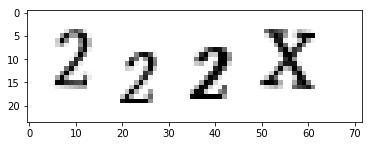

[INFO] Procesando Imagen para Entrenamiento 2/9955


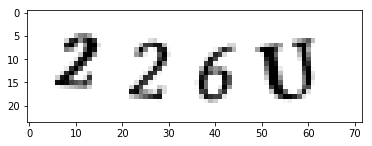

[INFO] Procesando Imagen para Entrenamiento 3/9955


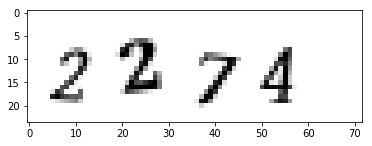

[INFO] Procesando Imagen para Entrenamiento 4/9955


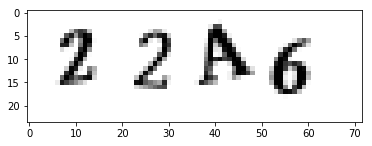

[INFO] Procesando Imagen para Entrenamiento 5/9955


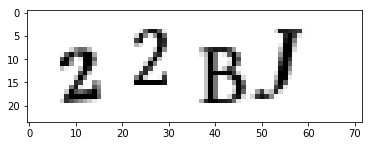

[INFO] Procesando Imagen para Entrenamiento 6/9955
[INFO] Procesando Imagen para Entrenamiento 7/9955
[INFO] Procesando Imagen para Entrenamiento 8/9955
[INFO] Procesando Imagen para Entrenamiento 9/9955
[INFO] Procesando Imagen para Entrenamiento 10/9955
[INFO] Procesando Imagen para Entrenamiento 11/9955
[INFO] Procesando Imagen para Entrenamiento 12/9955
[INFO] Procesando Imagen para Entrenamiento 13/9955
[INFO] Procesando Imagen para Entrenamiento 14/9955
[INFO] Procesando Imagen para Entrenamiento 15/9955
[INFO] Procesando Imagen para Entrenamiento 16/9955
[INFO] Procesando Imagen para Entrenamiento 17/9955
[INFO] Procesando Imagen para Entrenamiento 18/9955
[INFO] Procesando Imagen para Entrenamiento 19/9955
[INFO] Procesando Imagen para Entrenamiento 20/9955
[INFO] Procesando Imagen para Entrenamiento 21/9955
[INFO] Procesando Imagen para Entrenamiento 22/9955
[INFO] Procesando Imagen para Entrenamiento 23/9955
[INFO] Procesando Imagen para Entrenamiento 24/9955
[INFO] Procesand

In [1]:

import os
import os.path
import cv2
import glob
import imutils
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Ruta de las carpetas en las que tenemos las imágenes de muestra de los CAPTCHA 
# y en la que guardaremos cada caracter en carpetas
CAPTCHA_IMAGE_FOLDER = "CNN/TrainingData"
CAPTCHA_CHAR_FOLDER = "CNN/extracted_letter_images"

# Listado de todas las imágenes de muestra que usaremos para el entrenamiento
captcha_images = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
captcha_chars_counts = {}

# Loop por cada una de las imágenes
for (i, captcha_image_file) in enumerate(captcha_images):
    print("[INFO] Procesando Imagen para Entrenamiento {}/{}".format(i + 1, len(captcha_images)))

    # Cada archivo contiene el texto del CAPTCHA como nombre del archivo (i.e. "2A2X.png" contiene el texto "2A2X")
    # Obtenemos el nombre del archivo como String
    filename = os.path.basename(captcha_image_file)
    captcha_filename_split = os.path.splitext(filename)[0]

    # Cargamos la imagen y la convertimos a escala de grises
    captcha_individualChar_image = cv2.imread(captcha_image_file)
    captcha_image_gray = cv2.cvtColor(captcha_individualChar_image, cv2.COLOR_BGR2GRAY)

    # Le damos un padding a la imagen por los 4 costados.
    captcha_image_gray = cv2.copyMakeBorder(captcha_image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # Hacemos un threshold a la imagen (black and white conversion)
    captcha_image_threshold = cv2.threshold(captcha_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Buscamos los contornos
        # Se define el contorno como un conjunto de pixeles contínuos en la imagen
    captcha_image_contours = cv2.findContours(captcha_image_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Buscamos compatibilidad con otras versiones de OpenCV
    captcha_image_contours = captcha_image_contours[0] if imutils.is_cv2() else captcha_image_contours[1]

    # Creamos un array para los caracteres del CAPTCHA
    captcha_chars = []

    if i < 5:
        original_captcha = mpimg.imread(captcha_image_file)
        caprtchaPlot = plt.imshow(original_captcha)
        plt.show()

    # Hacemos un loop por cada uno de los contornos para quedarnos con la letra que contiene cada uno
    for contour in captcha_image_contours:
        # Obtenemos el rectángulo que contiene el contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Para evitar que 2 letras estén solapadas, comprobamos si la proporción entre alto y ancho es mayor al 1.25.
        # Si es más grande, probablemente contendrá 2 letras, así que las separaremos
        if w / h > 1.25:
            # Lo separamos por la mitad en 2 regiones
            center_width = int(w / 2)
            # Añadimos cada sección al array de caracteres
            captcha_chars.append((x, y, center_width, h))
            captcha_chars.append((x + center_width, y, center_width, h))
        else:
            # Añadimos la letra al array de caracteres
            captcha_chars.append((x, y, w, h))

    # Si encontramos más de 4 secciones (letras), algo habrá fallado.
    # Podemos buscar alternativas para corregirlas como la estrategia de separar en 2 las secciones.
    # No obstante, por no complicarlo más, vamos a ignorar esta imagen y no incluírla.
    if len(captcha_chars) != 4:
        continue

    # Para asegurarnos, ordenamos el array con los 4 contornos en base a su posición en el eje x, 
    # de forma que se encuentren de izquierda a derecha
    # Así nos aseguramos que asignemos la letra correspondiente a su segmento
    captcha_chars = sorted(captcha_chars, key=lambda x: x[0])

    # Guardamos cada letra como una imagen separada
    for captchaChar_contour_frame, char_string in zip(captcha_chars, captcha_filename_split):
        # Obtenemos las coordenadas de la letra en la imagen
        x, y, w, h = captchaChar_contour_frame

        # De la imagen original, extraemos el segmento correspondiente con un margen de 2 pixeles alrededor del borde.
        captcha_char_asImage = captcha_image_gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Obtenemos la ruta a la carpeta en la que guardarla
            # La carpeta a buscar tiene el nombre de la letra correspondiente
        captchaChars_files_path = os.path.join(CAPTCHA_CHAR_FOLDER, char_string)

        # Si no existe, creamos la carpeta
        if not os.path.exists(captchaChars_files_path):
            os.makedirs(captchaChars_files_path)

        # Guardamos el archivo en su carpeta correspondiente
            # Como nombre del archivo será 000000.png
            # Iremos incrementando el número según se vayan añadiendo más, 
            # de forma que no se sobre-escriba ninguna imagen
        specificChar_count = captcha_chars_counts.get(char_string, 1)
        captchaChar_fullPath = os.path.join(captchaChars_files_path, "{}.png".format(str(specificChar_count).zfill(6)))
        cv2.imwrite(captchaChar_fullPath, captcha_char_asImage)

        # Incrementamos el contador para esa letra concreta
        captcha_chars_counts[char_string] = specificChar_count + 1


Populating the interactive namespace from numpy and matplotlib
Muestra Imagen Procesada: 


/Users/pablomateofdez/anaconda3/envs/pmateoCAPTCHAS/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['contour']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


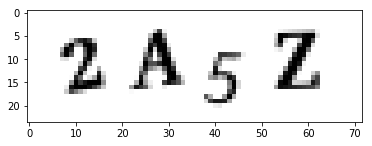

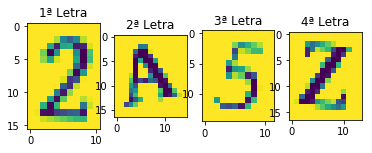

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Muestra Imagen Procesada: ")

original_captcha = mpimg.imread('CNN/TrainingData/2A5Z.png')
caprtchaPlot = plt.imshow(original_captcha)
plt.show()

original_captcha = mpimg.imread('CNN/extracted_letter_images/2/000001.png')
fig = plt.figure()
a = fig.add_subplot(1, 4, 1)
caprtchaPlot = plt.imshow(original_captcha)
a.set_title('1ª Letra')

original_captcha = mpimg.imread('CNN/extracted_letter_images/A/000001.png')
a = fig.add_subplot(1, 4, 2)
caprtchaPlot = plt.imshow(original_captcha)
caprtchaPlot.set_clim(0.0, 0.7)
a.set_title('2ª Letra')

original_captcha = mpimg.imread('CNN/extracted_letter_images/5/000001.png')
a = fig.add_subplot(1, 4, 3)
caprtchaPlot = plt.imshow(original_captcha)
caprtchaPlot.set_clim(0.0, 0.7)
a.set_title('3ª Letra')

original_captcha = mpimg.imread('CNN/extracted_letter_images/Z/000001.png')
a = fig.add_subplot(1, 4, 4)
caprtchaPlot = plt.imshow(original_captcha)
caprtchaPlot.set_clim(0.0, 0.7)
a.set_title('4ª Letra')

# Datos Entrenamiento preparados
Tras estos pasos previos, ya tenemos una serie de imágenes separadas en carpetas identificando a cada uno de los posibles carcateres. Vamso a usar esta información para entrenar una red neuronal y ver si es capaz de aprender a detectar nuevos CAPTCHAs de forma autónoma.<br>
Definimos una función de apoyo que modifique el tamaño de la imagen para unificarlas todas.

In [3]:
def imageToSize(image_to_modify, new_width, new_height):
    """
    Función que nos permite modificar a un tamaño concreto una imagen dada0
    :param image_to_modify: Imagen a modificar
    :param new_width: Nueva anchura (en px)
    :param new_height: Nueva altura (en px)
    :return: imagen modificada
    """

    # Obtenemos ancho y alto de la imagen
    (height, width) = image_to_modify.shape[:2]

    # Si la anchura es mayor que la altura, modificamos la anchura.
    if width > height:
        image_to_modify = imutils.resize(image_to_modify, width=new_width)

    # Si no, la inversa
    else:
        image_to_modify = imutils.resize(image_to_modify, height=new_height)

    # Para obtener el nuevo tamaño, determinamos el valor del padding de la anchura y altura
    widthPadding = int((new_width - image_to_modify.shape[1]) / 2.0)
    heightPadding = int((new_height - image_to_modify.shape[0]) / 2.0)

    # Ajustamos la imagen al nuevo tamaño propuesto
    image_to_modify = cv2.copyMakeBorder(image_to_modify, heightPadding, heightPadding, widthPadding, widthPadding,
                                         cv2.BORDER_REPLICATE)
    image_to_modify = cv2.resize(image_to_modify, (new_width, new_height))

    # Devolvemos la imagen modificada
    return image_to_modify

# Input Data
Una vez tenemos las imágenes de entrenamiento segmentadas, debemos prepararlas para pasárselas a nuestra red neuronal. Para ello, vamos a modificar el tamaño de las mismas (de forma que necesitemos menos capacidad de cálculo) y vamos a separarlas en 2 sets diferentes:<br>
- **Set Entrenamiento**
- **Set Pruebas**
<br><br>
Las 10.000 imágenes las separamos en 2 secciones para que una de ellas sirva como elementos de aprendizaje y la otra como set de validación. Es decir, pasaremos una serie de imágenes a la red para que aprenda a reconocerlas y, una vez hecho esto, le pasaremos el set de validación para que nos diga qué cree que pone en cada imagen. Como sabemos la respuesta, la red podrá comprobar su nivel de acierto e irá auto-ajustándose para ser cada vez más eficiente.

In [4]:
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

CAPTCHA_CHARACTERS_FOLDER_FILES = "CNN/extracted_letter_images"
TENSORFLOW_MODEL_NAME = "CNN/trainedModel/captcha_model.hdf5"
TENSORFLOW_MODEL_LABELS_NAME = "CNN/trainedModel/model_labels.dat"

# Creamos 2 arrays
    # Uno para los datos de entrenamiento de nuestra red
    # Otro para las etiquetas con los valores de los datos como validación
captcha_data = []
captcha_labels = []

# Hacemos un loop sobre todas las imágenes de la carpeta
for captcha_individualChars_files in paths.list_images(CAPTCHA_CHARACTERS_FOLDER_FILES):
    # Cargamos la imagen y la convertimos a escala de grises
    captcha_individualChar_image = cv2.imread(captcha_individualChars_files)
    captcha_individualChar_image = cv2.cvtColor(captcha_individualChar_image, cv2.COLOR_BGR2GRAY)

    # Reducimos la imagen a un tamaño de 20x20px
        # Así nuestra red no necesita procesar tanta información.
    captcha_individualChar_image = imageToSize(captcha_individualChar_image, 20, 20)

    # Añadimos un tercer canal de dimensión (requerido por Keras)
    captcha_individualChar_image = np.expand_dims(captcha_individualChar_image, axis=2)

    # Obtenemos el nombre de la carpeta para saber qué letra es
    charLabel = captcha_individualChars_files.split(os.path.sep)[-2]

    # Añadimos la imagen a nuestro array de dartos de entrenamiento
    captcha_data.append(captcha_individualChar_image)
    # Añadimos el label al de validación
    captcha_labels.append(charLabel)


# Una vez procesadas todas las imágenes de la carpeta

# Cada pixel contiene un valor RGB entre 0 y 255.
    # Para hacer más sencillo el entrenamiento, vamos a dejarlo en un valor entre 0 y 1
captcha_data = np.array(captcha_data, dtype="float") / 255.0
captcha_labels = np.array(captcha_labels)

# Debemos crear 2 sets para usar en nuestra Red Neuronal
    # Set de Entrenamiento
    # Set de pruebas
(X_train, X_test, Y_train, Y_test) = train_test_split(captcha_data, captcha_labels, test_size=0.25, random_state=0)

# No podemos entrenar nuestra red pasándole valores como "A", "H", etc
# Vamos a convertir los Labels a un valor numérico con el que podamos trabajar matemáticamente
    # Usamos One-Hot encoding
labels = LabelBinarizer().fit(Y_train)
Y_train = labels.transform(Y_train)
Y_test = labels.transform(Y_test)

with open(TENSORFLOW_MODEL_LABELS_NAME, "wb") as labelsFile:
    pickle.dump(labels, labelsFile)

Using TensorFlow backend.


# Convolutional Neural Network
Una vez tenemos la entrada de datos y testeo preparada, procedemos a generar el modelo de nuestra red.<br>
Vamos a utilizar **2 capas convolucionales** con **Max Pooling** y una **función relu de Activación**.<br>
Tras esto, añadiremos un **Hidden Layer** con 500 nodos y la misma función de activación.<br>
El **Output Layer** consistirá de 32 nodos (uno por cada posible caracter) y en este caso usaremos **softmax**.<br>
Finalmente, compilamos el modelo en **Keras** para poder usarlo con **TensorFlow**. Como **loss parameter** usaremos **Categorical CrossEntropy** y el **Adam Optimizer**.

In [5]:
# Creamos nuestra Neural Network!
neuralNet_model = Sequential()

# Convolutional layer con max pooling y relu como Activation Function
neuralNet_model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
neuralNet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional layer con max pooling y relu como Activation Function
neuralNet_model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
neuralNet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer con 500 nodos
neuralNet_model.add(Flatten())
neuralNet_model.add(Dense(500, activation="relu"))

# Output layer con 32 nodes (una por cada posible opción A-Z + 2-9)
neuralNet_model.add(Dense(32, activation="softmax"))

# Compilmos el modelo en Keras para usar con TensorFlow
neuralNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Entrenamiento
Una vez creado el modelo, lo entrenamos usando un **Batch Size** de 32 y 10 **Epochs**. Esto muestra un alto grado de efectividad, llegando por encima del 90% de acierto. Cambiando algunos parámetros del modelo, conseguimos un estable **100% de efectividad** a la hora de analizar los CAPTCHAS.

In [6]:
# Train the neural network
neuralNet_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=5, verbose=1)

Train on 29058 samples, validate on 9686 samples
Epoch 1/5
29058/29058 [==============================] - 28s 952us/step - loss: 0.2364 - acc: 0.9417 - val_loss: 0.0230 - val_acc: 0.9942

In [7]:
# Guardamos el modelo entrenado para poder utilizarlo cuando queramos sin tener que repetir el proceso.
neuralNet_model.save(TENSORFLOW_MODEL_NAME)

## Resumen
Mostramos un resumen de nuestro modelo.

In [8]:
neuralNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               625500    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16032     
Total para

# Proyecto Final
Una vez tenemos nuestra red entrenada, ya está lista para usar en el mundo real. Simplemente tendremos que pasar una imagen generada con este plugin y nuestra red será capaz de determinar su contenido con un altísimo grado de acierto. Como prueba, el siguiente código toma 10 imágenes de muestra de forma aleatoria y expone el resultado de su análisis.

In [27]:
from keras.models import load_model
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle

TENSORFLOW_MODEL_NAME = "CNN/trainedModel/captcha_model.hdf5"
TENSORFLOW_MODEL_LABELS_NAME = "CNN/trainedModel/model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "CNN/TrainingData"

# Cargamos las etiquetas del modelo
with open(TENSORFLOW_MODEL_LABELS_NAME, "rb") as labelsFile:
    labels = pickle.load(labelsFile)

# Cargamos la Red Neuronal ya entrenada
neuralNet_model = load_model(TENSORFLOW_MODEL_NAME)

# --------- . ---------
# Tomamos algunas imágenes de CAPTCHAs como ejemplos para testear la red.
# En lugar de estas imágenes, en un escenario real, tomaríamos la imagen del CAPTCHA en cuestión
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_images, size=(10,), replace=False)
#captcha_image_files = captcha_image_files[:10]

exampleAnalysisIncrement = 0
exampleAnalysisLabels = []

# Esto igual que el código que hemos visto al principio
    # Queremos hacer lo mismo, detectar las 4 letras
    # En esta ocasión, en lugar de guardar imágenes, le pasaremos la info a nuestra red 
    # para que nos detecte qué letra es.
for image_file in captcha_image_files:
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if imutils.is_cv2() else contours[1]
    letter_image_regions = []


    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))

    if len(letter_image_regions) != 4:
        continue

    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    output = cv2.merge([image] * 3)
    predictions = []

    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        letter_image = imageToSize(letter_image, 20, 20)
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        #----------------- Neural Network Implementation ---------------------- #
        # Pedimos a nuestra red que nos dé una predicción en base a su entrenamiento,
        prediction = neuralNet_model.predict(letter_image)

        # Convertimos la predicción de One-Hot Encoded a una letra normal
        letter = labels.inverse_transform(prediction)[0]
        predictions.append(letter)

        # Mostramos la predicción sobre la imagen
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Mostramos la solución
    captcha_text = "".join(predictions)
    print("CAPTCHA detectado: {}".format(captcha_text))
    exampleAnalysisLabels.append(captcha_text)

    cv2.imwrite('CNN/exampleAnalysis/workaround{}.jpg'.format(exampleAnalysisIncrement),output)
    exampleAnalysisIncrement += 1

CAPTCHA detectado: NX9V
CAPTCHA detectado: TG4X
CAPTCHA detectado: P7K9
CAPTCHA detectado: EBMW
CAPTCHA detectado: WXFK
CAPTCHA detectado: CYCL
CAPTCHA detectado: Q2MU
CAPTCHA detectado: 7CVT
CAPTCHA detectado: 68KJ
CAPTCHA detectado: FVW2


## Visualización
Podemos comprobar aquí debajo cómo nuestra red detecta cada caracter mostrando el resultado de una forma mucho más visual.

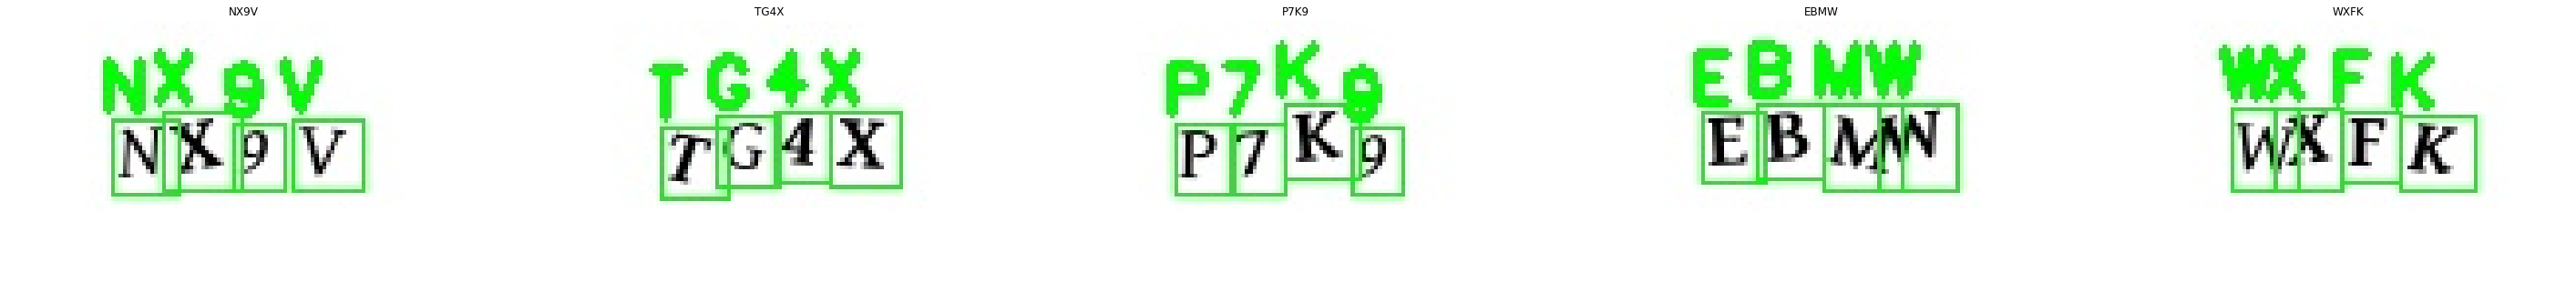

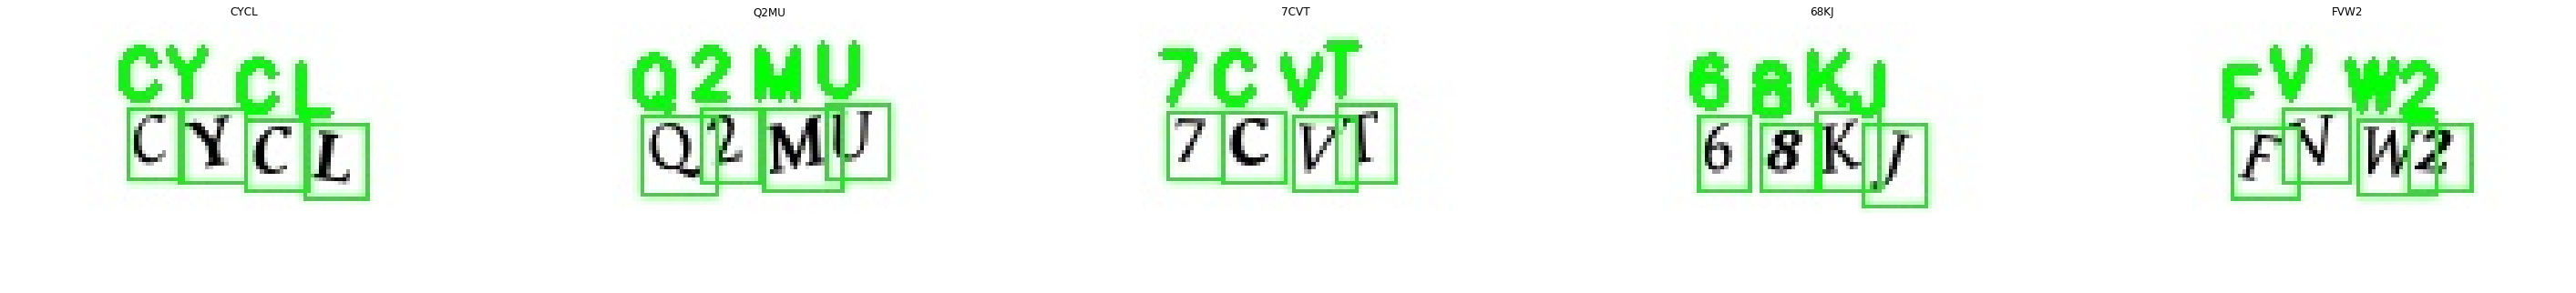

In [28]:
from IPython.display import Image
import cv2
import os
import glob

img_dir = "CNN/exampleAnalysis/"
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

#print(exampleAnalysisLabels)

images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in data]   
grid_display(images, exampleAnalysisLabels, 5, (50,50))